In [35]:
# Import necessary libraries

import pandas as pd 
import pyspark
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve

from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator,  BinaryClassificationEvaluator, RegressionEvaluator, MulticlassClassificationEvaluator


from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, avg, sum, max, date_sub, lit, current_date, datediff

In [36]:
### From official documentation
# Import SparkSession
from pyspark.sql import SparkSession

# Create SparkSession 
spark = SparkSession.builder \
      .master("local[1]") \
      .appName("my_pipeline") \
      .config("spark.sql.repl.eagerEval.enabled", True) \
      .getOrCreate()
print(spark.version)


# Load the dataset
df = spark.read.csv("../../ecommerce_data_with_trends.csv", header=True, inferSchema=True)

# Show the first 5 rows
df.show(5)



3.5.1
+--------------------+--------------------+-----------+--------------+-----------------+-------------+--------------------+--------------------+------+--------+------------+
|      transaction_id|           timestamp|customer_id| customer_name|             city|customer_type|        product_name|            category| price|quantity|total_amount|
+--------------------+--------------------+-----------+--------------+-----------------+-------------+--------------------+--------------------+------+--------+------------+
|TX_89a20095-f7be-...|2023-10-30 03:01:...|       6933|    David Hays|      New Sabrina|          B2C|Furniture Product_10|Home & Kitchen > ...|246.08|       4|      984.32|
|TX_a6b15a50-47b9-...|2023-10-30 03:06:...|       9328| Adam Oconnell|East Katherineton|          B2C|Non-Fiction Produ...| Books > Non-Fiction| 792.3|       4|      3169.2|
|TX_abdde2cb-3752-...|2023-10-30 03:06:...|       6766|   Jerry Brown|         Lukefort|          B2B|   Bedding Product_1|H

In [37]:
# Préparation des données
# Grouper les données par client pour obtenir un total des dépenses et une moyenne de quantité par client
df_grouped = df.groupBy("customer_id").agg(
    {"total_amount": "sum", "quantity": "avg"}
).withColumnRenamed("sum(total_amount)", "total_spent") \
 .withColumnRenamed("avg(quantity)", "avg_quantity")

# Assemblage des colonnes en un vecteur de caractéristiques pour K-means
vector_assembler = VectorAssembler(inputCols=["total_spent", "avg_quantity"], outputCol="features")
df_kmeans = vector_assembler.transform(df_grouped)

# Définir et entraîner le modèle K-means
kmeans = KMeans(featuresCol="features", k=2, seed=1)  # Ajuster k
model = kmeans.fit(df_kmeans)

# Faire des prédictions
predictions = model.transform(df_kmeans)

# Évaluer le modèle avec la métrique Silhouette
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score: {silhouette}")

# Afficher les clusters
predictions.select("customer_id", "total_spent", "avg_quantity", "prediction").show(5)



Silhouette Score: 0.9797099332079754
+-----------+------------------+------------------+----------+
|customer_id|       total_spent|      avg_quantity|prediction|
+-----------+------------------+------------------+----------+
|       7754| 3509355.630000001| 59.24074074074074|         0|
|       1591|         134225.55|3.0114942528735633|         1|
|       4101|        2316585.25| 51.23529411764706|         0|
|       6357|        2448142.84| 55.52272727272727|         0|
|        833|181201.25000000006|             2.872|         1|
+-----------+------------------+------------------+----------+
only showing top 5 rows



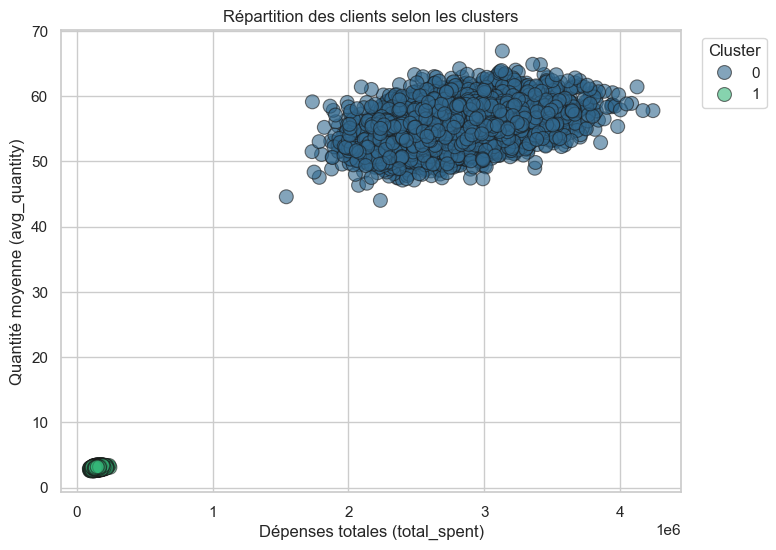

In [38]:
# Convertir les résultats en Pandas DataFrame pour visualisation
pandas_df = predictions.select("customer_id", "total_spent", "avg_quantity", "prediction").toPandas()

# Paramétrer le style de Seaborn pour de meilleurs visuels
sns.set_theme(style="whitegrid")

# Créer le scatter plot
plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(
    data=pandas_df, 
    x="total_spent", 
    y="avg_quantity", 
    hue="prediction", 
    palette="viridis", 
    s=100, 
    alpha=0.6,
    edgecolor="k"
)

# Ajouter des titres et labels
plt.title("Répartition des clients selon les clusters")
plt.xlabel("Dépenses totales (total_spent)")
plt.ylabel("Quantité moyenne (avg_quantity)")
plt.legend(title="Cluster", loc="upper right", bbox_to_anchor=(1.15, 1))
plt.savefig("../output/kmeans_clusters.png")
plt.show()


In [39]:
# Feature engineering
customer_features = df.groupBy("customer_id").agg(
    sum("total_amount").alias("total_spent"),
    count("transaction_id").alias("number_of_transactions"),
    avg("total_amount").alias("avg_transaction_value"),
    max("timestamp").alias("last_purchase_date")
)

# Calculer la récence et créer une étiquette (au lieu de churn)
final_df = customer_features.withColumn(
    "recency_days", 
    datediff(current_date(), col("last_purchase_date"))
).withColumn(
    "label",  # Changed from "churn" to "label"
    when(col("recency_days") > 90, 1.0).otherwise(0.0)
)

# Préparation des caractéristiques pour le modèle
feature_columns = ["total_spent", "number_of_transactions", "avg_transaction_value", "recency_days"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
model_data = assembler.transform(final_df)

# Split data
train_data, test_data = model_data.randomSplit([0.7, 0.3], seed=42)

# Créer et entraîner le modèle
lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=10
)

model = lr.fit(train_data)


Model Accuracy: 1.0
+-----------+-----+----------+
|customer_id|label|prediction|
+-----------+-----+----------+
|          3|  0.0|       0.0|
|          7|  0.0|       0.0|
|          9|  0.0|       0.0|
|         10|  0.0|       0.0|
|         14|  0.0|       0.0|
+-----------+-----+----------+
only showing top 5 rows


Feature Importance:
total_spent: 0.0
number_of_transactions: 0.0
avg_transaction_value: 0.0
recency_days: 0.0


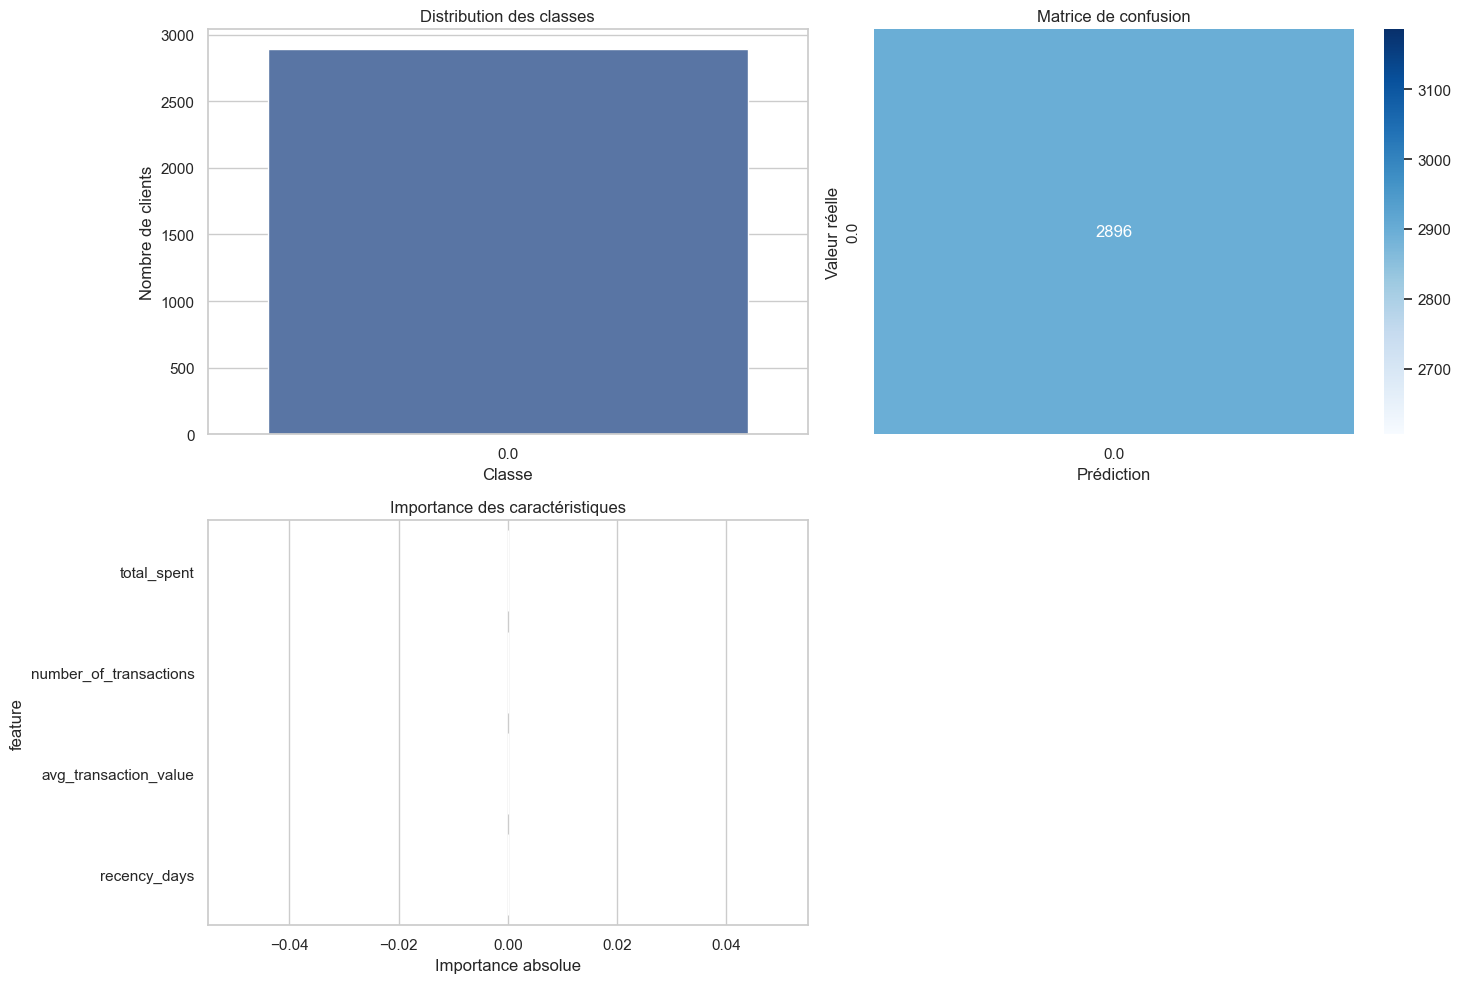

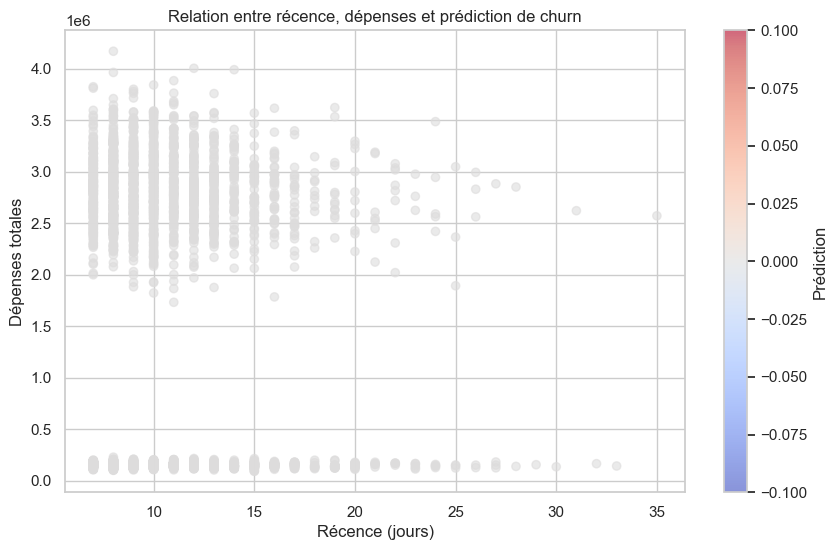

In [43]:
# Faire des prédictions
predictions = model.transform(test_data)

# Évaluer le modèle
evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

# Calculer la précision
accuracy = evaluator.evaluate(predictions)
print(f"Model Accuracy: {accuracy}")

# Afficher des prédictions d'échantillons
predictions.select("customer_id", "label", "prediction").show(5)

# Obtenir l'importance des caractéristiques
feature_importance = list(zip(feature_columns, model.coefficients))
print("\nFeature Importance:")
for feature, importance in feature_importance:
    print(f"{feature}: {importance}")

plt.figure(figsize=(15, 10))

# 1. Distribution des classes
plt.subplot(2, 2, 1)
class_counts = predictions.groupBy("label").count().toPandas()
sns.barplot(x="label", y="count", data=class_counts)
plt.title("Distribution des classes")
plt.xlabel("Classe")
plt.ylabel("Nombre de clients")

# 2. Matrice de confusion
plt.subplot(2, 2, 2)
conf_matrix = predictions.groupBy("label", "prediction").count().toPandas()
conf_matrix_pivot = conf_matrix.pivot(index="label", columns="prediction", values="count").fillna(0)
sns.heatmap(conf_matrix_pivot, annot=True, fmt="g", cmap="Blues")
plt.title("Matrice de confusion")
plt.xlabel("Prédiction")
plt.ylabel("Valeur réelle")

# 3. Feature Importance Plot
plt.subplot(2, 2, 3)
feature_imp_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': np.abs(model.coefficients.toArray())  # Convert to numpy array before taking absolute value
})
feature_imp_df = feature_imp_df.sort_values('importance', ascending=True)
sns.barplot(x='importance', y='feature', data=feature_imp_df)
plt.title("Importance des caractéristiques")
plt.xlabel("Importance absolue")

# Ajuster la mise en page et sauvegarder
plt.tight_layout()
plt.savefig("../output/model_analysis.png")
plt.show()

# Graphique supplémentaire pour la récence vs probabilité de churn
plt.figure(figsize=(10, 6))
predictions_pd = predictions.select("recency_days", "prediction", "total_spent").toPandas()
plt.scatter(predictions_pd["recency_days"], predictions_pd["total_spent"], 
           c=predictions_pd["prediction"], cmap="coolwarm", alpha=0.6)
plt.colorbar(label="Prédiction")
plt.xlabel("Récence (jours)")
plt.ylabel("Dépenses totales")
plt.title("Relation entre récence, dépenses et prédiction de churn")
plt.savefig("../output/recency_spending_analysis.png")
plt.show()